### Part 1 - Introduction

### Concept

* Compute a coefficient for each attribute
* Select a subset of attributes based on the coefficient

### Different methods of computing the coefficient

#### Classification Methods

**`f_classif`**

> Computes ANOVA F-value between each feature and the target (for classification).
> 
> Measures linear dependency; higher F-value means stronger feature importance.

**`mutual_info_classif`**

> Estimates mutual information (dependency) between features and a discrete target.
> 
> Captures non-linear relationships (unlike F-value).

**`chi2`**

> Computes Chi-squared statistic between categorical features and target.
> 
> Only works with non-negative features (e.g., counts, binary data).

#### Regression Methods

**`f_regression`**

> Computes F-value between features and a continuous target.
> 
> Measures linear correlation (similar to Pearson’s correlation).

**`mutual_info_regression`**

> Estimates mutual information between features and a continuous target.
> 
> Detects non-linear dependencies (more general than F-value).

### Different methods of selecting attributes

#### Feature Selection Wrappers

**`SelectKBest`**

> Selects first k features based on scores (e.g., F-value, mutual info).

**`SelectPercentile`**

> Selects top X% of features based on scores.

**`SelectFpr`** (False Positive Rate)

> Selects features with p-values below a threshold (controls false positives).

**`SelectFdr`** (False Discovery Rate)

> Adjusts p-values using Benjamini-Hochberg procedure to limit false discoveries.

**`SelectFwe`** (Family-Wise Error Rate)

> Uses Bonferroni correction to control overall error rate (strict threshold).


### Part 2 - Scikit learn demo
#### Part 2.1 - Base code

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [92]:
# Load and clean data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)

print("Nombre d'entrées et nombre de colonnes :")
print(data.shape)

# Define X and y
X = data.drop(columns=['class'])
y = data['class']

Nombre d'entrées et nombre de colonnes :
(768, 9)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)

scores = np.nan_to_num(selector.scores_, nan=0.0)

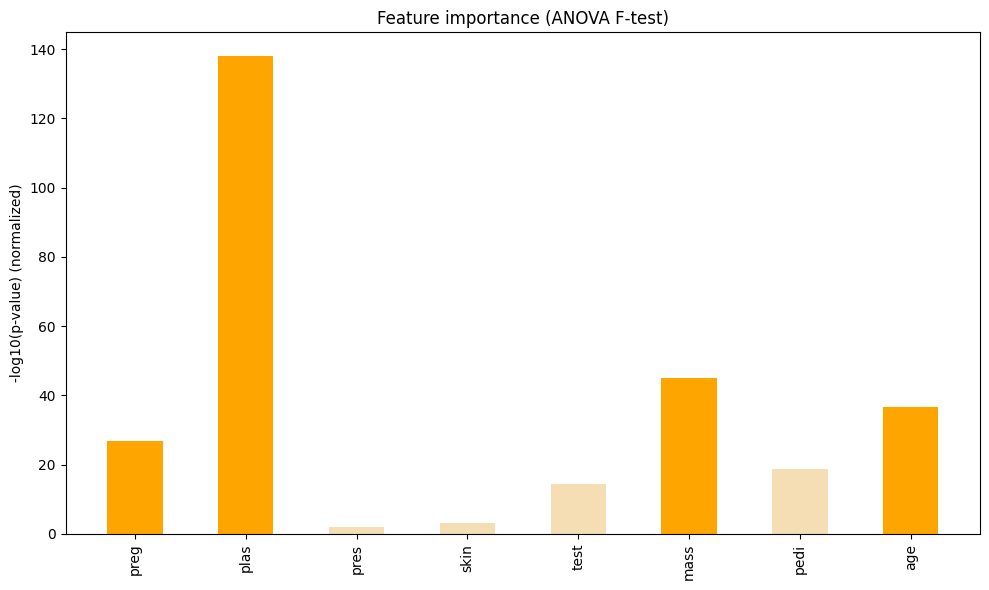

In [94]:
plt.figure(figsize=(10, 6))
top_k_indices = np.argsort(scores)[-4:]
colors = ['orange' if i in top_k_indices else 'wheat' for i in range(len(scores))]
plt.bar(range(len(scores)), scores, tick_label=X.columns, width=0.5, color=colors)
plt.xticks(rotation=90)
plt.ylabel("-log10(p-value) (normalized)")
plt.title("Feature importance (ANOVA F-test)")
plt.tight_layout()
plt.show()

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(selector, MinMaxScaler(), LinearSVC())

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with top 4 features: {accuracy:.3f}")

Accuracy with top 4 features: 0.766


#### Part 2.2 - Comparison with different methods

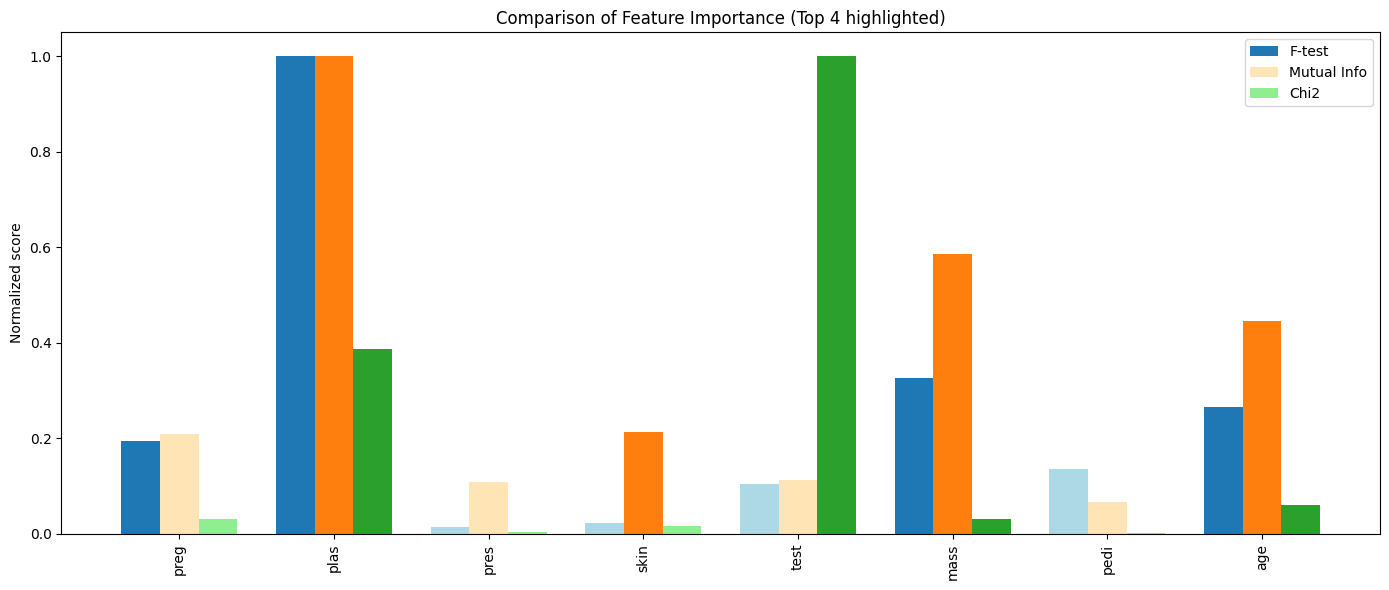

In [96]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Scoring functions
methods = {
    'F-test': f_classif,
    'Mutual Info': mutual_info_classif,
    'Chi2': chi2
}

# Color palette: (bright color, light version)
colors_map = {
    'F-test': ('tab:blue', 'lightblue'),
    'Mutual Info': ('tab:orange', 'moccasin'),
    'Chi2': ('tab:green', 'lightgreen')
}

all_scores = {}
acc_scores = {}

clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_scores["nothing"] = accuracy_score(y_test, y_pred)

for name, score_func in methods.items():
    selector = SelectKBest(score_func=score_func, k='all')
    selector.fit(X_train, y_train)
    scores = np.nan_to_num(selector.scores_, nan=0.0)
    scores /= np.nanmax(scores)
    all_scores[name] = scores


    clf = make_pipeline(MinMaxScaler(), LinearSVC())
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_scores[name] = accuracy_score(y_test, y_pred)


# Plotting
labels = X.columns
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(14, 6))

for idx, (method_name, scores) in enumerate(all_scores.items()):
    bright, light = colors_map[method_name]
    offset = (idx - 1) * width

    # Highlight top 4 features
    top_k = np.argsort(scores)[-4:]
    bar_colors = [bright if i in top_k else light for i in range(len(scores))]

    plt.bar(x + offset, scores, width, label=method_name, color=bar_colors)

plt.xticks(x, labels, rotation=90)
plt.ylabel("Normalized score")
plt.title("Comparison of Feature Importance (Top 4 highlighted)")
plt.legend()
plt.tight_layout()
plt.show()


([0, 1, 2, 3],
 [Text(0, 0, 'nothing'),
  Text(1, 0, 'F-test'),
  Text(2, 0, 'Mutual Info'),
  Text(3, 0, 'Chi2')])

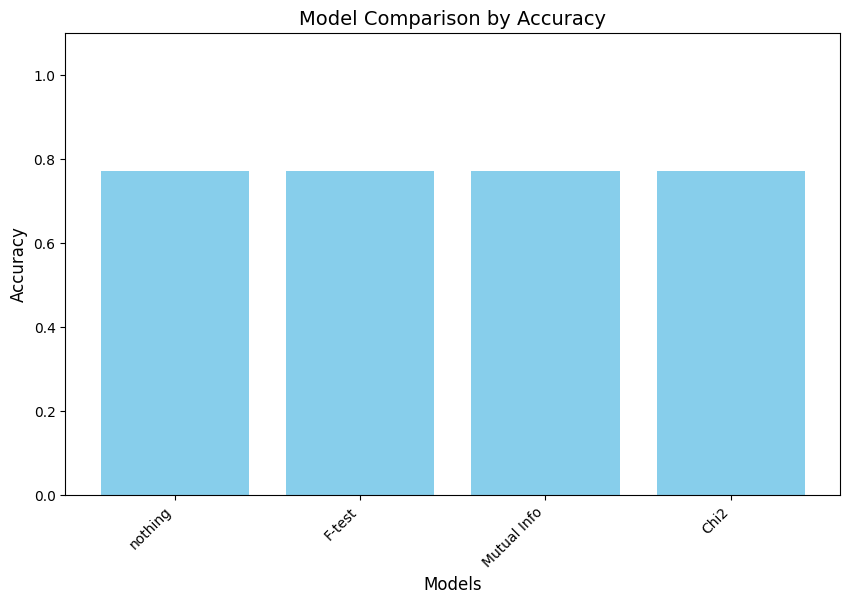

In [98]:

# Assuming acc_scores looks like: {'Model1': 0.95, 'Model2': 0.88, ...}
models = list(acc_scores.keys())
scores = list(acc_scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color='skyblue')

# Customize the chart
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison by Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # Set y-axis limit to accommodate 100% accuracy
plt.xticks(rotation=45, ha='right')  # Rotate model names if long